<div style="display:block;border:solid red 3px;padding:2em">
    
## RESOURCES FOR YOU 
**<font color='red'>(Delete from final notebook)</font>**

- [OVERVIEW OF OSEMiN](#OVERVIEW-OF-OSEMiN)
- [PROCESS-CHECKLIST](#PROCESS-CHECKLIST)
    - Can actually keep this part if you'd like.
- [LINKS FOR MOD 1 PROJECT](#LINKS-FOR-MOD-1-PROJECT)


### Study Group Recordings Playlist
-  Project Specific:
    - [Intro to Mod Project from 100719PT Cohort]( https://youtu.be/Uy9O1NcjZ68?t=2274)

- 4-Part Lessons for Regression (100719PT cohort)
    - https://www.youtube.com/playlist?list=PLFknVelSJiSzPeEKXfAFYjzzzvK8zr_qA

## OVERVIEW OF OSEMiN


<div style="display:block;border:solid red 3px;padding:2em">
    
<img src='https://raw.githubusercontent.com/jirvingphd/fsds_100719_cohort_notes/master/images/OSEMN.png' width=800>
<center><a href="https://www.kdnuggets.com/2018/02/data-science-command-line-book-exploring-data.html"> 
    </a></center>


> <font size=4em>The Data Science Process we'll be using during this section--OSEMiN (pronounced "OH-sum", rhymes with "possum").  This is the most straightforward of the Data Science Processes discussed so far.  **Note that during this process, just like the others, the stages often blur together.***  It is completely acceptable (and ***often a best practice!) to float back and forth** between stages as you learn new things about your problem, dataset, requirements, etc.  
It's quite common to get to the modeling step and realize that you need to scrub your data a bit more or engineer a different feature and jump back to the "Scrub" stage, or go all the way back to the "Obtain" stage when you realize your current data isn't sufficient to solve this problem. 
As with any of these frameworks, *OSEMiN is meant to be treated as guidelines, not law. 
</font>


### OSEMN DETAILS

**OBTAIN**

- This step involves understanding stakeholder requirements, gathering information on the problem, and finally sourcing data that we think will be necessary for solving this problem. 

**SCRUB**

- During this stage, we'll focus on preprocessing our data.  Important steps such as identifying and removing null values, dealing with outliers, normalizing data, and feature engineering/feature selection are handled around this stage.  The line with this stage really blurs with the _Explore_ stage, as it is common to only realize that certain columns require cleaning or preprocessing as a result of the visualzations and explorations done during Step 3.  

- Note that although technically, categorical data should be one-hot encoded during this step, in practice, it's usually done after data exploration.  This is because it is much less time-consuming to visualize and explore a few columns containing categorical data than it is to explore many different dummy columns that have been one-hot encoded. 

**EXPLORE**

- This step focuses on getting to know the dataset you're working with. As mentioned above, this step tends to blend with the _Scrub_ step mentioned above.  During this step, you'll create visualizations to really get a feel for your dataset.  You'll focus on things such as understanding the distribution of different columns, checking for multicollinearity, and other tasks liek that.  If your project is a classification task, you may check the balance of the different classes in your dataset.  If your problem is a regression task, you may check that the dataset meets the assumptions necessary for a regression task.  

- At the end of this step, you should have a dataset ready for modeling that you've thoroughly explored and are extremely familiar with.  

**MODEL**

- This step, as with the last two frameworks, is also pretty self-explanatory. It consists of building and tuning models using all the tools you have in your data science toolbox.  In practice, this often means defining a threshold for success, selecting machine learning algorithms to test on the project, and tuning the ones that show promise to try and increase your results.  As with the other stages, it is both common and accepted to realize something, jump back to a previous stage like _Scrub_ or _Explore_, and make some changes to see how it affects the model.  

**iNTERPRET**

- During this step, you'll interpret the results of your model(s), and communicate results to stakeholders.  As with the other frameworks, communication is incredibily important! During this stage, you may come to realize that further investigation is needed, or more data.  That's totally fine--figure out what's needed, go get it, and start the process over! If your results are satisfactory to all stakeholders involved, you may also go from this stage right into productionizing your model and automating processes necessary to support it.  



<font color='red'>Note: Delete this markdown cell from your final project notebook</font>
</div>

## PROCESS CHECKLIST


> Keep in mind that it is normal to jump between the OSEMN phases and some of them will blend together, like SCRUB and EXPLORE.

1. **[OBTAIN](#OBTAIN)**
    - Import data, inspect, check for datatypes to convert and null values
    - Display header and info.
    - Drop any unneeded columns, if known (`df.drop(['col1','col2'],axis=1,inplace=True`)
    <br><br>


2. **[SCRUB](#SCRUB)**
    - Recast data types, identify outliers, check for multicollinearity, normalize data**
    - Check and cast data types
        - [ ] Check for #'s that are store as objects (`df.info()`,`df.describe()`)
            - when converting to #'s, look for odd values (like many 0's), or strings that can't be converted.
            - Decide how to deal weird/null values (`df.unique()`, `df.isna().sum()`)
            - `df.fillna(subset=['col_with_nulls'],'fill_value')`, `df.replace()`
        - [ ] Check for categorical variables stored as integers.
            - May be easier to tell when you make a scatter plotm or `pd.plotting.scatter_matrix()`
            
    - [ ] Check for missing values  (df.isna().sum())
        - Can drop rows or colums
        - For missing numeric data with median or bin/convert to categorical
        - For missing categorical data: make NaN own category OR replace with most common category
    - [ ] Check for multicollinearity
        - Use seaborn to make correlation matrix plot 
        - Good rule of thumb is anything over 0.75 corr is high, remove the variable that has the most correl with the largest # of variables
    - [ ] Normalize data (may want to do after some exploring)
        - Most popular is Z-scoring (but won't fix skew) 
        - Can log-transform to fix skewed data
    
    
3. **[EXPLORE](#EXPLORE)**
    - [ ] Check distributions, outliers, etc**
    - [ ] Check scales, ranges (df.describe())
    - [ ] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform.
        - Can also do kernel density estimates
    - [ ] Use scatter plots to check for linearity and possible categorical variables (`df.plot("x","y")`)
        - categoricals will look like vertical lines
    - [ ] Use `pd.plotting.scatter_matrix(df)` to visualize possible relationships
    - [ ] Check for linearity.
   
   
4. **[MODEL](#MODEL)**

    - **Fit an initial model:** 
        - Run an initial model and get results

    - **Holdout validation / Train/test split**
        - use sklearn `train_test_split`
    
    
5. **[iNTERPRET](#iNTERPRET)**
    - **Assessing the model:**
        - Assess parameters (slope,intercept)
        - Check if the model explains the variation in the data (RMSE, F, R_square)
        - *Are the coeffs, slopes, intercepts in appropriate units?*
        - *Whats the impact of collinearity? Can we ignore?*
        <br><br>
    - **Revise the fitted model**
        - Multicollinearity is big issue for lin regression and cannot fully remove it
        - Use the predictive ability of model to test it (like R2 and RMSE)
        - Check for missed non-linearity
        
       
6. **Interpret final model and draw >=3 conclusions and recommendations from dataset**

<div style="display:block;border-bottom:solid red 3px;padding:2em;color:red;">
DELETE ABOVE THIS LINE FROM YOUR FINAL NOTEBOOK
</div>

# Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time:
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:
* Video of 5-min Non-Technical Presentation:

## TABLE OF CONTENTS 

*Click to jump to matching Markdown Header.*<br><br>

<font size=3rem>
    
- **[Introduction](#INTRODUCTION)<br>**
- **[OBTAIN](#OBTAIN)**<br>
- **[SCRUB](#SCRUB)**<br>
- **[EXPLORE](#EXPLORE)**<br>
- **[MODEL](#MODEL)**<br>
- **[iNTERPRET](#iNTERPRET)**<br>
- **[Conclusions/Recommendations](#CONCLUSIONS-&-RECOMMENDATIONS)<br>**
</font>
___

# INTRODUCTION

> Explain the point of your project and what question you are trying to answer with your modeling.



# OBTAIN

In [1]:
#IMPORTING
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
sns.set_style('darkgrid')

from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import scipy.stats as stats
from sklearn.model_selection import train_test_split

In [2]:
#OPENING DATASET 
pd.set_option('display.max_columns',0)
df = pd.read_csv('kc_house_data.csv')
df.drop(columns = 'id',inplace = True)
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,5/21/2014,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,2/23/2015,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,6/23/2014,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,1/16/2015,400000.0,3,2.50,1600,2388,2.0,NaN,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [3]:
#GETTING DATA INFO
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 20 columns):
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(10), object(2)
memory usage: 3.3+ MB


In [4]:
#GETTING DATA BASIC STATS
df.describe()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.159700e+04,21597.000000,21597.000000,21597.000000,2.159700e+04,21597.000000,19221.000000,21534.000000,21597.000000,21597.000000,21597.000000,21597.000000,17755.000000,21597.000000,21597.000000,21597.000000,21597.000000,21597.000000
mean,5.402966e+05,3.373200,2.115826,2080.321850,1.509941e+04,1.494096,0.007596,0.233863,3.409825,7.657915,1788.596842,1970.999676,83.636778,98077.951845,47.560093,-122.213982,1986.620318,12758.283512
std,3.673681e+05,0.926299,0.768984,918.106125,4.141264e+04,0.539683,0.086825,0.765686,0.650546,1.173200,827.759761,29.375234,399.946414,53.513072,0.138552,0.140724,685.230472,27274.441950
min,7.800000e+04,1.000000,0.500000,370.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,3.000000,370.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,3.220000e+05,3.000000,1.750000,1430.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,1951.000000,0.000000,98033.000000,47.471100,-122.328000,1490.000000,5100.000000
50%,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,1975.000000,0.000000,98065.000000,47.571800,-122.231000,1840.000000,7620.000000
75%,6.450000e+05,4.000000,2.500000,2550.000000,1.068500e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


In [5]:
#LOOKING AT NULL VALUES
df.isna().sum()

date                0
price               0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2376
view               63
condition           0
grade               0
sqft_above          0
sqft_basement       0
yr_built            0
yr_renovated     3842
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
dtype: int64

# SCRUB (DATA CLEANING)

In [6]:
#WANT TO FILL ALL NULL VALUES IN WATERFRONT WITH DISTRIBUTION OF 146:19075
s = df.waterfront.value_counts(normalize = True)
print(s)

0.0    0.992404
1.0    0.007596
Name: waterfront, dtype: float64


In [7]:
waterfront_null = df.waterfront.isnull()
df.loc[waterfront_null,'waterfront'] = np.random.choice(s.index,size=len(df[waterfront_null]),p=s.values)
print(df.waterfront.value_counts())

0.0    21438
1.0      159
Name: waterfront, dtype: int64


In [8]:
#CONVERTING DATE FROM OBJECT TO DATE
df.date = pd.to_datetime(df.date)

In [9]:
#REPLACE ? WITH 0 IN SQFT_BASEMENT
df.sqft_basement.replace('?',0,inplace = True)

In [10]:
#REPLACING ALL NULL VALUES IN YR_RENOVATED TO 0 BECAUSE MAJORITY IS 0
for index, col in enumerate(df.yr_renovated.isnull()):
    if col == True:
        df.yr_renovated[index] = 0
df

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,1933,0.0,98028,47.7379,-122.233,2720,8062
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0.0,0.0,3,8,1530,0.0,2009,0.0,98103,47.6993,-122.346,1530,1509
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0.0,0.0,3,8,2310,0.0,2014,0.0,98146,47.5107,-122.362,1830,7200
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0.0,0.0,3,7,1020,0.0,2009,0.0,98144,47.5944,-122.299,1020,2007
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0.0,0.0,3,8,1600,0.0,2004,0.0,98027,47.5345,-122.069,1410,1287


In [11]:
#TURNING VALUES FROM FLOAT TO INT
float_list = ['sqft_basement','waterfront','yr_renovated']
for col in float_list:
    df[col] = pd.to_numeric(df[col]).astype(int).round(0)

In [12]:
#CREATING YEAR SOLD AND RENOVATION FRESHNESS COLUMNS
df['year_sold'] = pd.DatetimeIndex(df['date']).year
df['renovation_freshness'] = 0

In [13]:
#REPLACING 2015 YEAR RENOVATED AND YEAR BUILT WITH 2014 BECAUSE HOUSE WAS SOLD IN 2014
for i, yr in enumerate(df['year_sold']):
    if yr < df['yr_renovated'][i]:
        df['yr_renovated'][i] = yr
    elif yr < df['yr_built'][i]:
        df['yr_built'][i] = yr


C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [14]:
#CREATING HOUSE AGE WHEN SOLD COLUMNS AND FILLING IN RENOVATION FRESHNESS COLUMN
df['house_age_when_sold'] = df['date'].dt.year - df['yr_built'] 
for index, yr in enumerate(df['yr_renovated']):
    if yr != 0:
        df['renovation_freshness'][index] = df['year_sold'][index] - df['yr_renovated'][index]
    else:
        df['renovation_freshness'][index] = df['house_age_when_sold'][index]
df

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovation_freshness,house_age_when_sold
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0.0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,59,59
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,23,63
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0.0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,82,82
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0.0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,49,49
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0.0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,28,28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0.0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,5
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0.0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,1,1
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0.0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,5,5
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0.0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,11,11


In [15]:
#ZIPCODE TO SUB_REGION DF
subregion_df = pd.read_excel('SubRegZipCityNeighborhood.xlsx')
subregion_df

,zipcode,Sub_Region
0,98001,South_Urban
1,98002,South_Urban
2,98003,South_Urban
3,98004,East_Urban
4,98005,East_Urban
...,...,...
116,98199,Seattle
117,98224,East_Rural
118,98251,East_Rural
119,98288,East_Rural


In [16]:
df = df.join(subregion_df.set_index('zipcode'),on = 'zipcode')
df

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovation_freshness,house_age_when_sold,Sub_Region
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,0,0.0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650,2014,59,59,South_Urban
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,0,0.0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014,23,63,Seattle
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,0,0.0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062,2015,82,82,North
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,0,0.0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000,2014,49,49,Seattle
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,0,0.0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503,2015,28,28,East_Urban
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,0,0.0,3,8,1530,0,2009,0,98103,47.6993,-122.346,1530,1509,2014,5,5,Seattle
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,0,0.0,3,8,2310,0,2014,0,98146,47.5107,-122.362,1830,7200,2015,1,1,South_and_Seattle
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,0,0.0,3,7,1020,0,2009,0,98144,47.5944,-122.299,1020,2007,2014,5,5,Seattle
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,0,0.0,3,8,1600,0,2004,0,98027,47.5345,-122.069,1410,1287,2015,11,11,East_Urban


In [17]:
df['Sub_Region'].value_counts()

Seattle              6233
East_Urban           5694
South_Urban          5278
North                1197
South_Rural           922
East_Rural            922
North_and_Seattle     748
South_and_Seattle     288
West                  198
Vashon_Island         117
Name: Sub_Region, dtype: int64

In [18]:
#DROPPING VIEW COLUMN
df.drop('view',axis = 1,inplace =  True)

In [19]:
#DATAFRAME INFO AFTER REMOVING NULL VALUES
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 23 columns):
date                    21597 non-null datetime64[ns]
price                   21597 non-null float64
bedrooms                21597 non-null int64
bathrooms               21597 non-null float64
sqft_living             21597 non-null int64
sqft_lot                21597 non-null int64
floors                  21597 non-null float64
waterfront              21597 non-null int32
condition               21597 non-null int64
grade                   21597 non-null int64
sqft_above              21597 non-null int64
sqft_basement           21597 non-null int32
yr_built                21597 non-null int64
yr_renovated            21597 non-null int32
zipcode                 21597 non-null int64
lat                     21597 non-null float64
long                    21597 non-null float64
sqft_living15           21597 non-null int64
sqft_lot15              21597 non-null int64
year_sold        

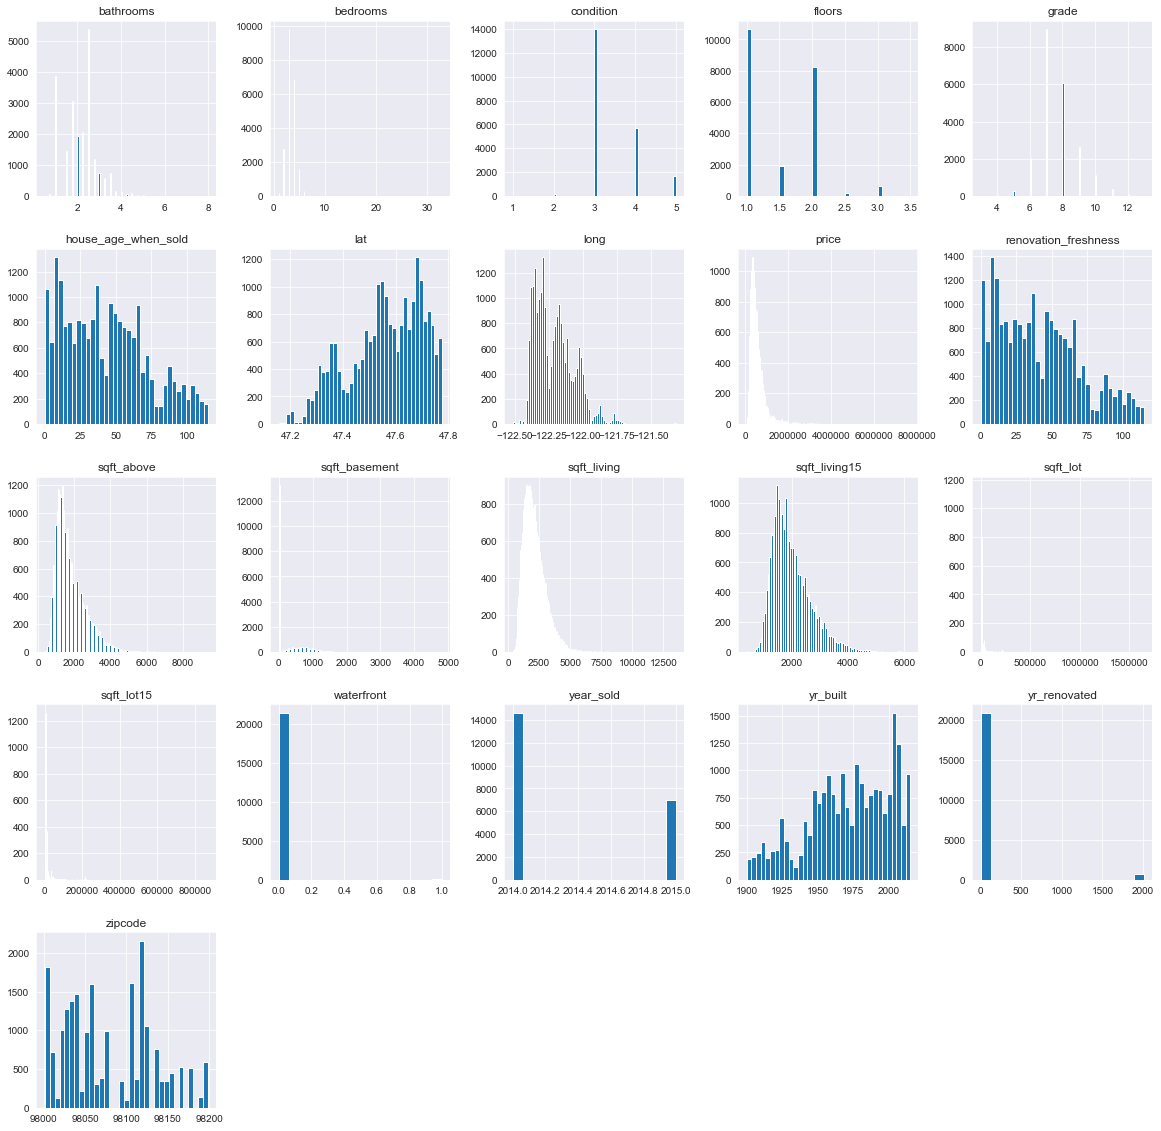

In [20]:
df.hist(figsize = (20,20), bins = 'auto');

In [21]:
#REMOVING EXTREME OUTLIERS
outliers_list = ['bedrooms','sqft_basement','sqft_above','sqft_living','sqft_lot','sqft_lot15','price']
for i in outliers_list:
    orig_tot = len(df)
    df = df[df[i] <= df[i].quantile(q=0.97)] # Subsetting to remove extreme outliers
    print('Percent removed:', (orig_tot -len(df))/orig_tot)

Percent removed: 0.015465110895031718
Percent removed: 0.028876452052861778
Percent removed: 0.029589810644583273
Percent removed: 0.02994310809462022
Percent removed: 0.030044243234900708
Percent removed: 0.030020154874297232
Percent removed: 0.02930883639545057


In [22]:
#TURNING SQFT BASEMENT COLUMN INTO BINARY (CONTAINS BASEMENT OR NOT)
df['has_basement'] = 0
for index,basement in enumerate(df['sqft_basement']):
    if basement > 0:
        df['has_basement'][index] = 1
df.drop('sqft_basement',axis = 1, inplace = True)

C:\Users\Biel_\anaconda3\envs\learn-env\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


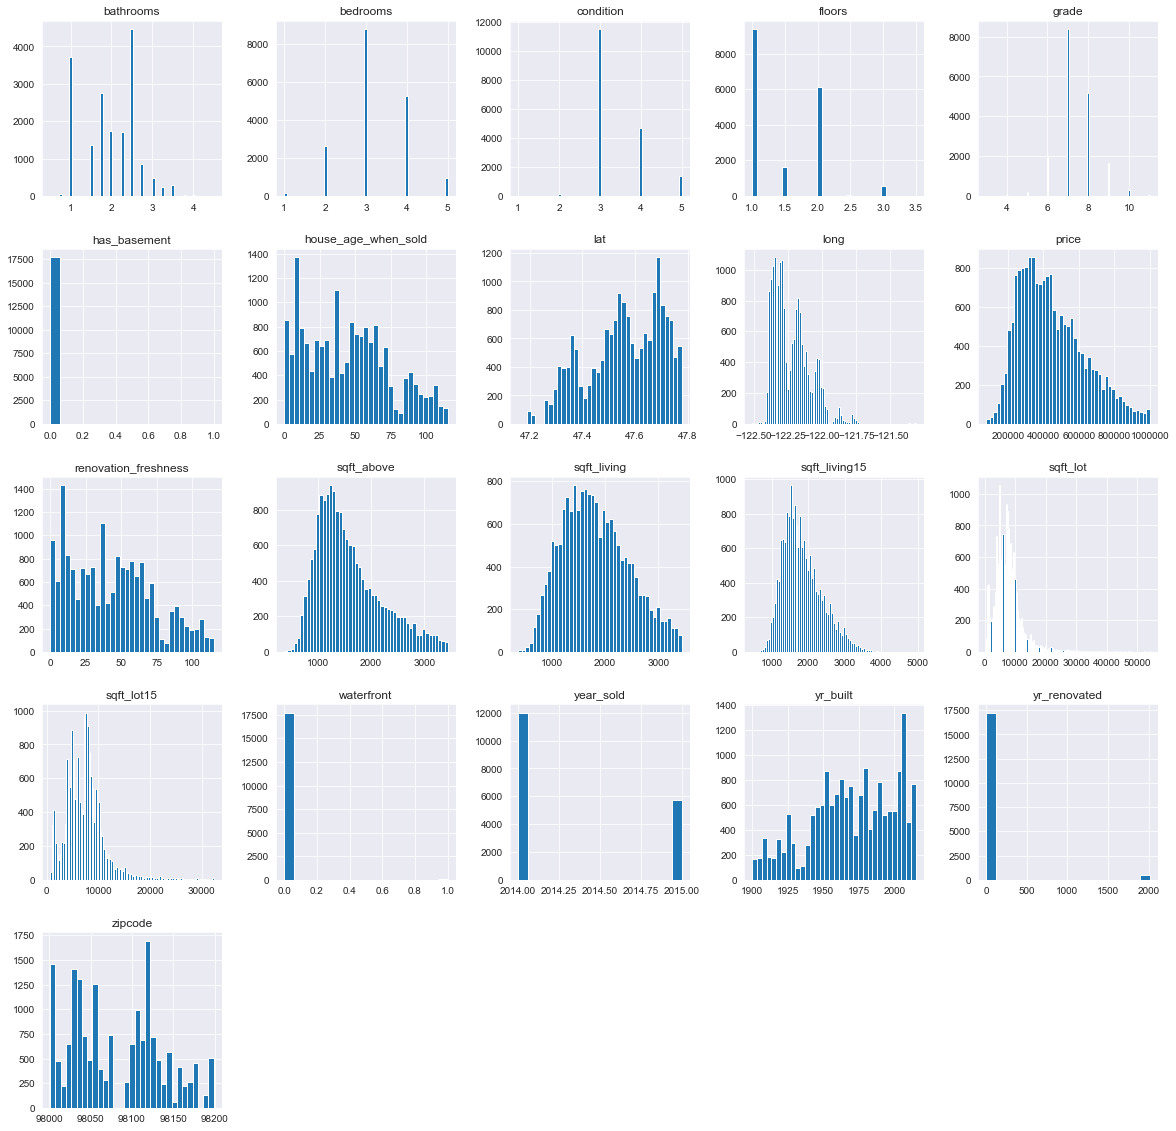

In [23]:
df.hist(figsize = (20,20), bins = 'auto');

In [24]:
#TURNING COLUMNS TO STRING FOR HOT ENCODING
categories = ['Sub_Region','waterfront']
for cat in categories:
    df[cat] = df[cat].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17752 entries, 0 to 21596
Data columns (total 23 columns):
date                    17752 non-null datetime64[ns]
price                   17752 non-null float64
bedrooms                17752 non-null int64
bathrooms               17752 non-null float64
sqft_living             17752 non-null int64
sqft_lot                17752 non-null int64
floors                  17752 non-null float64
waterfront              17752 non-null object
condition               17752 non-null int64
grade                   17752 non-null int64
sqft_above              17752 non-null int64
yr_built                17752 non-null int64
yr_renovated            17752 non-null int32
zipcode                 17752 non-null int64
lat                     17752 non-null float64
long                    17752 non-null float64
sqft_living15           17752 non-null int64
sqft_lot15              17752 non-null int64
year_sold               17752 non-null int64
renovation_fresh

# EXPLORE

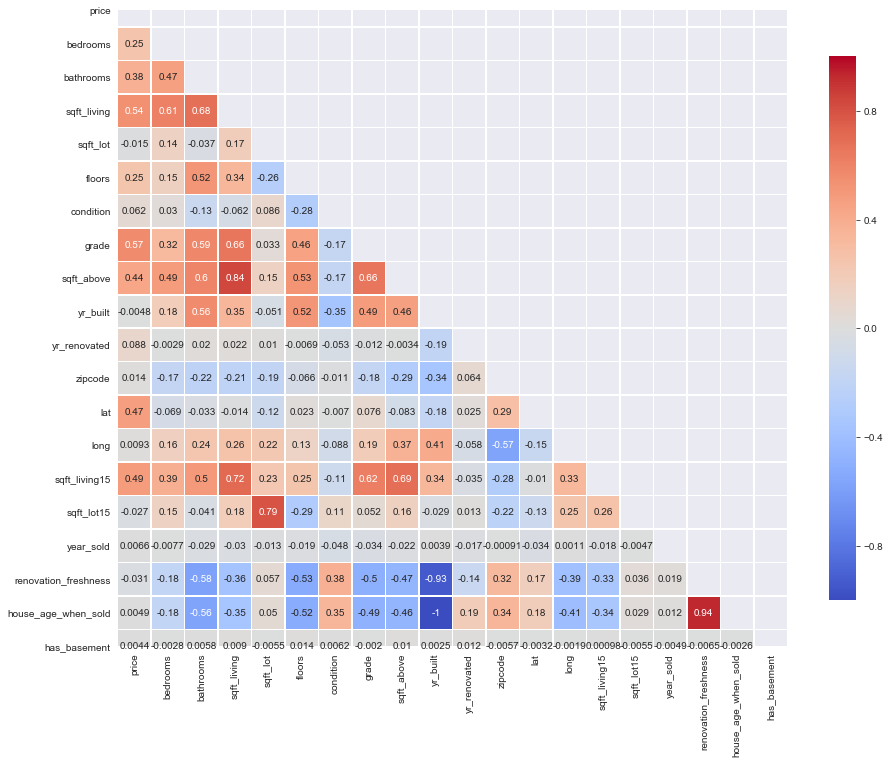

In [25]:
#CORRELATION HEATMAP
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [26]:
#DROPPING COLUMNS WITH HIGH CORRELATION
df.drop('sqft_above',axis = 1,inplace=True)
df.drop('yr_built',axis = 1,inplace=True)

In [ ]:
x_cols_list = ['sqft_living','sqft_lot','renovation_freshness','house_age_when_sold']
for x_col in x_cols_list:

    figure = plt.figure
    ax = plt.gca()
    ax.scatter(df[x_col], df['price'])
    ax.set_xlabel(x_col)
    ax.set_ylabel('PRICE')
    ax.set_title("{} vs {}".format(x_col, 'Price'))

    plt.legend()
    plt.show()

In [27]:
#HOT ENCODING
dummies = pd.get_dummies(df[categories],prefix = categories,drop_first = True)
df_preprocessed = df.drop(categories,axis = 1)
df_preprocessed = pd.concat([df_preprocessed,dummies],axis = 1)
df_preprocessed

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovation_freshness,house_age_when_sold,has_basement,Sub_Region_East_Urban,Sub_Region_North,Sub_Region_North_and_Seattle,Sub_Region_Seattle,Sub_Region_South_Rural,Sub_Region_South_Urban,Sub_Region_South_and_Seattle,Sub_Region_Vashon_Island,Sub_Region_West,waterfront_1
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,0,98178,47.5112,-122.257,1340,5650,2014,59,59,0,0,0,0,0,0,1,0,0,0,0
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,1991,98125,47.7210,-122.319,1690,7639,2014,23,63,1,0,0,0,1,0,0,0,0,0,0
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,0,98028,47.7379,-122.233,2720,8062,2015,82,82,0,0,1,0,0,0,0,0,0,0,0
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,0,98136,47.5208,-122.393,1360,5000,2014,49,49,1,0,0,0,1,0,0,0,0,0,0
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,0,98074,47.6168,-122.045,1800,7503,2015,28,28,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,3,8,0,98103,47.6993,-122.346,1530,1509,2014,5,5,0,0,0,0,1,0,0,0,0,0,0
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,3,8,0,98146,47.5107,-122.362,1830,7200,2015,1,1,0,0,0,0,0,0,0,1,0,0,0
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,3,7,0,98144,47.5944,-122.299,1020,2007,2014,5,5,0,0,0,0,1,0,0,0,0,0,0
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,3,8,0,98027,47.5345,-122.069,1410,1287,2015,11,11,0,1,0,0,0,0,0,0,0,0,0


In [53]:
df_preprocessed['log_price'] = df_preprocessed['price'].map(lambda x :np.log(x))
df_preprocessed

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year_sold,renovation_freshness,house_age_when_sold,has_basement,Sub_Region_East_Urban,Sub_Region_North,Sub_Region_North_and_Seattle,Sub_Region_Seattle,Sub_Region_South_Rural,Sub_Region_South_Urban,Sub_Region_South_and_Seattle,Sub_Region_Vashon_Island,Sub_Region_West,waterfront_1,log_price
0,2014-10-13,221900.0,3,1.00,1180,5650,1.0,3,7,0,98178,47.5112,-122.257,1340,5650,2014,59,59,0,0,0,0,0,0,1,0,0,0,0,12.309982
1,2014-12-09,538000.0,3,2.25,2570,7242,2.0,3,7,1991,98125,47.7210,-122.319,1690,7639,2014,23,63,1,0,0,0,1,0,0,0,0,0,0,13.195614
2,2015-02-25,180000.0,2,1.00,770,10000,1.0,3,6,0,98028,47.7379,-122.233,2720,8062,2015,82,82,0,0,1,0,0,0,0,0,0,0,0,12.100712
3,2014-12-09,604000.0,4,3.00,1960,5000,1.0,5,7,0,98136,47.5208,-122.393,1360,5000,2014,49,49,1,0,0,0,1,0,0,0,0,0,0,13.311329
4,2015-02-18,510000.0,3,2.00,1680,8080,1.0,3,8,0,98074,47.6168,-122.045,1800,7503,2015,28,28,0,1,0,0,0,0,0,0,0,0,0,13.142166
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21592,2014-05-21,360000.0,3,2.50,1530,1131,3.0,3,8,0,98103,47.6993,-122.346,1530,1509,2014,5,5,0,0,0,0,1,0,0,0,0,0,0,12.793859
21593,2015-02-23,400000.0,4,2.50,2310,5813,2.0,3,8,0,98146,47.5107,-122.362,1830,7200,2015,1,1,0,0,0,0,0,0,0,1,0,0,0,12.899220
21594,2014-06-23,402101.0,2,0.75,1020,1350,2.0,3,7,0,98144,47.5944,-122.299,1020,2007,2014,5,5,0,0,0,0,1,0,0,0,0,0,0,12.904459
21595,2015-01-16,400000.0,3,2.50,1600,2388,2.0,3,8,0,98027,47.5345,-122.069,1410,1287,2015,11,11,0,1,0,0,0,0,0,0,0,0,0,12.899220


In [55]:
#DEFINING TARGET AND PREDICTORS
y = 'log_price'
df_predictors = df_preprocessed.drop(['log_price','price','date','zipcode'],axis = 1)
X = list(df_predictors.columns)

In [56]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_preprocessed[X], df_preprocessed[y], test_size=0.3, random_state=42)
print(len(X_train), len(X_test), len(y_train), len(y_test))

12426 5326 12426 5326


In [57]:
train_df = pd.concat([y_train,X_train],axis=1)
test_df = pd.concat([y_test,X_test],axis=1)

In [58]:
#FITTING MODEL
predictors = '+'.join(X_train.columns)
formula = y + '~' + predictors
model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1604.
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:34   Log-Likelihood:                 2173.5
No. Observations:               12426   AIC:                            -4293.
Df Residuals:                   12399   BIC:                            -4092.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     -156.3075      8.826    -17.711      0.000    -173.607    -139.008
bedrooms                        -0.0076      0.003     -2.570      0.010      -0.013      -0.002
bathrooms                        0.0421      0.005      9.111      0.000       0.033       0.051
sqft_living                      0.0002   5.86e-06     31.900      0.000       0.000       0.000
sqft_lot                      1.492e-06   5.67e-07      2.632      0.009    3.81e-07     2.6e-06
floors                           0.0190      0.005      4.044      0.000       0.010       0.028
condition                        0.0708      0.003     22.556      0.000       0.065       0.077
grade                            0.1193      0.003     37.766      0.000       0.113       0.125
yr_renovated                  2.364e-05   1.44e-05      1.637      0.102   -4.67e-06    5.19e-05
lat                              1.0138      0.027     37.102      0.000       0.960       1.067
long                            -0.1464      0.029     -5.023      0.000      -0.204      -0.089
sqft_living15                    0.0001   5.45e-06     24.863      0.000       0.000       0.000
sqft_lot15                   -2.377e-06   8.09e-07     -2.938      0.003   -3.96e-06   -7.91e-07
year_sold                        0.0502      0.004     12.809      0.000       0.043       0.058
renovation_freshness            -0.0005      0.000     -1.050      0.294      -0.001       0.000
house_age_when_sold              0.0023      0.000      5.005      0.000       0.001       0.003
has_basement                    -0.0275      0.053     -0.522      0.601      -0.131       0.076
Sub_Region_East_Urban            0.1379      0.013     10.624      0.000       0.112       0.163
Sub_Region_North                -0.1830      0.017    -10.675      0.000      -0.217      -0.149
Sub_Region_North_and_Seattle    -0.1359      0.020     -6.869      0.000      -0.175      -0.097
Sub_Region_Seattle               0.1640      0.018      9.336      0.000       0.130       0.198
Sub_Region_South_Rural           0.0134      0.016      0.845      0.398      -0.018       0.045
Sub_Region_South_Urban          -0.1519      0.016     -9.439      0.000      -0.183      -0.120
Sub_Region_South_and_Seattle    -0.0831      0.023     -3.595      0.000      -0.128      -0.038
Sub_Region_Vashon_Island         0.1139      0.051      2.252      0.024       0.015       0.213
Sub_Region_West                 -0.1143      0.037     -3.080      0.002      -0.187      -0.042
waterfront_1                     0.4891      0.040     12.236      0.000       0.411       0.567
==============================================================================
Omnibus:                      665.553   Durbin-Watson:                   1.999
Prob(Omnibus): 

In [ ]:
#CORRELATION HEATMAP
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

f, ax = plt.subplots(figsize=(15, 20))

sns.heatmap(corr, mask=mask, cmap='coolwarm', vmax=1, center=0,
            square=True, linewidths=.5,annot=True, cbar_kws={"shrink": .5});

In [ ]:
model.pvalues

In [59]:
# Your code here - Remove features which do not appear to be statistically relevant
summary = model.summary()
p_table = summary.tables[1]
p_table = pd.DataFrame(p_table.data)
p_table.columns = p_table.iloc[0]
p_table = p_table.drop(0)
p_table = p_table.set_index(p_table.columns[0])
p_table['P>|t|'] = p_table['P>|t|'].astype(float)
x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
x_cols.remove('Intercept')
print(len(p_table), len(x_cols))

27 22


In [60]:
predictors = '+'.join(x_cols)
formula = y + '~' + predictors
model = ols(formula=formula, data=train_df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.770
Model:                            OLS   Adj. R-squared:                  0.770
Method:                 Least Squares   F-statistic:                     1888.
Date:                Sun, 26 Jul 2020   Prob (F-statistic):               0.00
Time:                        19:43:58   Log-Likelihood:                 2151.0
No. Observations:               12426   AIC:                            -4256.
Df Residuals:                   12403   BIC:                            -4085.
Df Model:                          22                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
Intercept                     -155.9448      8.815    -17.691      0.000    -173.223    -138.666
bedrooms                        -0.0082      0.003     -2.763      0.006      -0.014      -0.002
bathrooms                        0.0461      0.005     10.058      0.000       0.037       0.055
sqft_living                      0.0002   5.86e-06     31.953      0.000       0.000       0.000
sqft_lot                      1.422e-06   5.68e-07      2.505      0.012    3.09e-07    2.53e-06
floors                           0.0205      0.005      4.352      0.000       0.011       0.030
condition                        0.0677      0.003     21.808      0.000       0.062       0.074
grade                            0.1205      0.003     38.196      0.000       0.114       0.127
lat                              0.9977      0.024     40.898      0.000       0.950       1.046
long                            -0.1553      0.028     -5.628      0.000      -0.209      -0.101
sqft_living15                    0.0001   5.44e-06     24.401      0.000       0.000       0.000
sqft_lot15                   -2.264e-06   8.09e-07     -2.800      0.005   -3.85e-06   -6.79e-07
year_sold                        0.0499      0.004     12.705      0.000       0.042       0.058
house_age_when_sold              0.0020      0.000     20.018      0.000       0.002       0.002
Sub_Region_East_Urban            0.1305      0.010     12.713      0.000       0.110       0.151
Sub_Region_North                -0.1901      0.015    -12.292      0.000      -0.220      -0.160
Sub_Region_North_and_Seattle    -0.1444      0.018     -8.123      0.000      -0.179      -0.110
Sub_Region_Seattle               0.1527      0.014     10.633      0.000       0.125       0.181
Sub_Region_South_Urban          -0.1640      0.011    -15.044      0.000      -0.185      -0.143
Sub_Region_South_and_Seattle    -0.0934      0.020     -4.677      0.000      -0.133      -0.054
Sub_Region_Vashon_Island         0.1009      0.049      2.068      0.039       0.005       0.196
Sub_Region_West                 -0.1209      0.037     -3.292      0.001      -0.193      -0.049
waterfront_1                     0.4966      0.040     12.414      0.000       0.418       0.575
==============================================================================
Omnibus:                      673.307   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1744.473
Skew:                          -0.304   Prob(JB):                         0.00
Kurtosis:                       4.732   Cond. No.                     6.19e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is corre

In [ ]:
# summary = model.summary()
# p_table = summary.tables[1]
# p_table = pd.DataFrame(p_table.data)
# p_table.columns = p_table.iloc[0]
# p_table = p_table.drop(0)
# p_table = p_table.set_index(p_table.columns[0])
# p_table['P>|t|'] = p_table['P>|t|'].astype(float)
# x_cols = list(p_table[p_table['P>|t|'] < 0.05].index)
# x_cols.remove('Intercept')
# print(len(p_table), len(x_cols))

In [ ]:
# # Your code here - Refit the model
# predictors = '+'.join(x_cols)
# formula = y + '~' + predictors
# model = ols(formula=formula, data=train_df).fit()
# model.summary()

In [ ]:
# # Your code here - Code a way to identify multicollinearity
# from statsmodels.stats.outliers_influence import variance_inflation_factor

In [ ]:
# X = df_preprocessed[x_cols]
# vif = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
# vif_dict = dict(zip(x_cols, vif))
# print(len(vif_dict))
# vif_dict_2 = {}
# for key,value in vif_dict.items():
#     if value < 10:
#         vif_dict_2[key] = value
# print(vif_dict_2)

In [ ]:
# x_cols = list(vif_dict_2.keys())
# predictors = '+'.join(x_cols)
# formula = y + '~' + predictors
# model = ols(formula=formula, data=train_df).fit()
# model.summary()

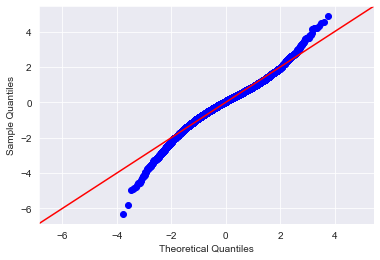

In [61]:
# Your code here - Check that the residuals are normally distributed
fig = sm.graphics.qqplot(model.resid, dist=stats.norm, line='45', fit=True)

In [62]:
plt.scatter(train_df['price'],model.resid)


KeyError: 'price'

In [ ]:
# Your code here - Check that the residuals are homoscedastic
plt.scatter(model.predict(train_df[x_cols]), model.resid)
plt.plot(model.predict(train_df[x_cols]), [0 for i in range(len(train_df))])

# MODEL

# iNTERPRET

# CONCLUSIONS & RECOMMENDATIONS

> Summarize your conclusions and bullet-point your list of recommendations, which are based on your modeling results.